In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 220
TIMESTEPS = 1
EPOCH=400
BATCH_SIZE=10

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 2

DATASET_DIR_NAME = "dataset\set04\\01_own"
SAMPLE_DATASET_NAME = "own_train"
ACTUAL_DATASET_NAME = "own_test"

MODEL_DIR_NAME = "dataset\set04\\01_own"
MODEL_NAME = "model_" + "set04_01_own"

RESULT_DIR_NAME = "dataset\set04\\01_own"
RESULT_NAME = "result_" + "set04_01_own"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own\own_train.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,Co5mical,0.124989,0.000000,0.124989,0.123640,0.248628,0.123640,0.011015,0.134655,...,0.005318,0.005458,0.055285,0.056239,0.072921,0.073875,0.606169,0.731157,0.718543,0.843531
1,andy,Co5mical,0.101935,0.011014,0.112950,0.133594,0.235529,0.122580,0.046207,0.168787,...,0.006047,0.003990,0.047034,0.032436,0.077762,0.063164,0.616391,0.718327,0.697449,0.799384
2,andy,Co5mical,0.090341,-0.012504,0.077837,0.090850,0.181191,0.103354,0.054714,0.158068,...,0.003187,0.002233,0.024718,0.015517,0.056457,0.047256,0.550968,0.641309,0.628636,0.718976
3,andy,Co5mical,0.102711,0.011565,0.114277,0.110634,0.213346,0.099069,0.033884,0.132953,...,0.004878,0.005244,0.046083,0.048659,0.069841,0.072416,0.562252,0.664963,0.652923,0.755634
4,andy,Co5mical,0.127922,0.063317,0.191239,0.188074,0.315996,0.124757,0.023144,0.147900,...,0.016760,0.017344,0.101889,0.104127,0.129459,0.131697,0.638064,0.765986,0.722751,0.850673


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


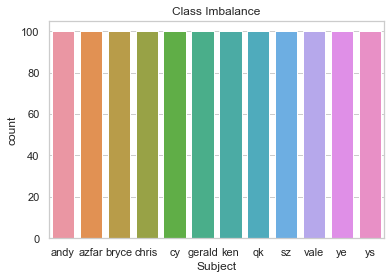

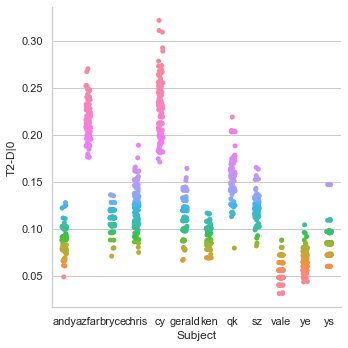

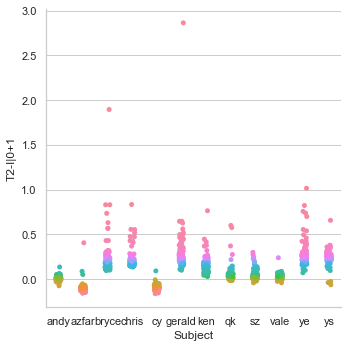

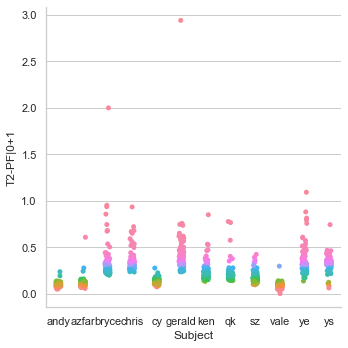

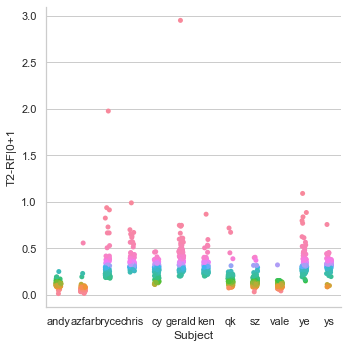

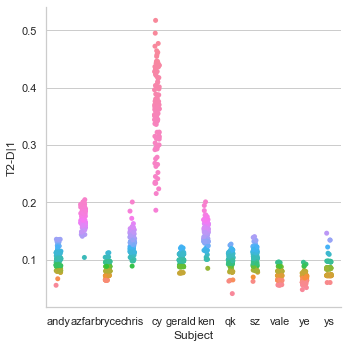

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'bryce' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye'
 'ys']


X | Features | Dataset Shape: (1200, 220)
Y | Classes  | Dataset Shape: (1200, 12)
Number of Classes: 12


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (960, 1, 220)
Y train shape: (960, 12)
X test shape: (240, 1, 220)
Y test shape: (240, 12)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 12 classes.
Epoch 1/400
77/77 [==============================] - 7s 10ms/step - loss: 2.6310 - accuracy: 0.0885
Epoch 2/400
77/77 [==============================] - 1s 11ms/step - loss: 2.5168 - accuracy: 0.1016
Epoch 3/400
77/77 [==============================] - 1s 10ms/step - loss: 2.4017 - accuracy: 0.1445
Epoch 4/400
77/77 [==============================] - 1s 9ms/step - loss: 2.2609 - accuracy: 0.1875
Epoch 5/400
77/77 [==============================] - 1s 9ms/step - loss: 2.1571 - accuracy: 0.2279
Epoch 6/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0645 - accuracy: 0.2266
Epoch 7/400
77/77 [==============================] - 1s 10ms/step - loss: 1.9885 - accuracy: 0.2695
Epoch 8/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9205 - accuracy: 0.2474
Epoch 9/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9217 - accuracy: 0.2487
Epoch 10/400
77/77 [==============================] - 1s 9ms/step - loss

77/77 [==============================] - 1s 9ms/step - loss: 1.1256 - accuracy: 0.5182
Epoch 83/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0967 - accuracy: 0.5286
Epoch 84/400
77/77 [==============================] - 1s 9ms/step - loss: 1.3152 - accuracy: 0.5091
Epoch 85/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1865 - accuracy: 0.5208
Epoch 86/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1203 - accuracy: 0.5391
Epoch 87/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0943 - accuracy: 0.5365
Epoch 88/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0959 - accuracy: 0.5651
Epoch 89/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1711 - accuracy: 0.5208
Epoch 90/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0624 - accuracy: 0.5560
Epoch 91/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0743 - accuracy: 0.5599
Epoch 92/400


77/77 [==============================] - 1s 10ms/step - loss: 0.7899 - accuracy: 0.7344
Epoch 164/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8107 - accuracy: 0.7461
Epoch 165/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7806 - accuracy: 0.7292
Epoch 166/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7637 - accuracy: 0.7396
Epoch 167/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6700 - accuracy: 0.7591
Epoch 168/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7917 - accuracy: 0.7292
Epoch 169/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8656 - accuracy: 0.7135
Epoch 170/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8205 - accuracy: 0.7253
Epoch 171/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8208 - accuracy: 0.7240
Epoch 172/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8475 - accuracy: 0.7

77/77 [==============================] - 1s 9ms/step - loss: 0.6080 - accuracy: 0.8138
Epoch 245/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5858 - accuracy: 0.8021
Epoch 246/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6548 - accuracy: 0.7826
Epoch 247/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6023 - accuracy: 0.8086
Epoch 248/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6795 - accuracy: 0.7982
Epoch 249/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6364 - accuracy: 0.8086
Epoch 250/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6042 - accuracy: 0.8177
Epoch 251/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5491 - accuracy: 0.8229
Epoch 252/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6877 - accuracy: 0.7826
Epoch 253/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5901 - accuracy: 0.7917
Epoc

77/77 [==============================] - 1s 9ms/step - loss: 0.5092 - accuracy: 0.8490
Epoch 326/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5144 - accuracy: 0.8607
Epoch 327/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4841 - accuracy: 0.8698
Epoch 328/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4936 - accuracy: 0.8568
Epoch 329/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4162 - accuracy: 0.8893
Epoch 330/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4505 - accuracy: 0.8698
Epoch 331/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4003 - accuracy: 0.8867
Epoch 332/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4988 - accuracy: 0.8594
Epoch 333/400
77/77 [==============================] - 1s 13ms/step - loss: 0.4075 - accuracy: 0.8854
Epoch 334/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4487 - accuracy: 0.8958

77/77 [==============================] - 1s 8ms/step - loss: 2.1167 - accuracy: 0.2227
Epoch 6/400
77/77 [==============================] - 1s 8ms/step - loss: 2.0480 - accuracy: 0.2292
Epoch 7/400
77/77 [==============================] - 1s 8ms/step - loss: 1.9427 - accuracy: 0.2448
Epoch 8/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9235 - accuracy: 0.2357
Epoch 9/400
77/77 [==============================] - 1s 9ms/step - loss: 1.8999 - accuracy: 0.2201
Epoch 10/400
77/77 [==============================] - 1s 11ms/step - loss: 1.9046 - accuracy: 0.2214
Epoch 11/400
77/77 [==============================] - 1s 11ms/step - loss: 1.8586 - accuracy: 0.2292
Epoch 12/400
77/77 [==============================] - 1s 11ms/step - loss: 1.8852 - accuracy: 0.2461
Epoch 13/400
77/77 [==============================] - 1s 11ms/step - loss: 1.8630 - accuracy: 0.2201
Epoch 14/400
77/77 [==============================] - 1s 11ms/step - loss: 1.8144 - accuracy: 0.2461
Epoch 15/400

77/77 [==============================] - 1s 10ms/step - loss: 1.1277 - accuracy: 0.5482
Epoch 87/400
77/77 [==============================] - 1s 10ms/step - loss: 1.2301 - accuracy: 0.5156
Epoch 88/400
77/77 [==============================] - 1s 10ms/step - loss: 1.2139 - accuracy: 0.5326
Epoch 89/400
77/77 [==============================] - 1s 10ms/step - loss: 1.2474 - accuracy: 0.4974
Epoch 90/400
77/77 [==============================] - 1s 10ms/step - loss: 1.2016 - accuracy: 0.5352
Epoch 91/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1466 - accuracy: 0.5521
Epoch 92/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1099 - accuracy: 0.5755
Epoch 93/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0602 - accuracy: 0.5820
Epoch 94/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0945 - accuracy: 0.5716
Epoch 95/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0823 - accuracy: 0.5690
Epo

77/77 [==============================] - 1s 10ms/step - loss: 0.8500 - accuracy: 0.6862
Epoch 167/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8203 - accuracy: 0.7135
Epoch 168/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9832 - accuracy: 0.6367
Epoch 169/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9089 - accuracy: 0.6823
Epoch 170/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8780 - accuracy: 0.6888
Epoch 171/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7895 - accuracy: 0.6914
Epoch 172/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7852 - accuracy: 0.7253
Epoch 173/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8987 - accuracy: 0.6745
Epoch 174/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8160 - accuracy: 0.6979
Epoch 175/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7064 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.6239 - accuracy: 0.7917
Epoch 247/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7317 - accuracy: 0.7565
Epoch 248/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6982 - accuracy: 0.7943
Epoch 249/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5919 - accuracy: 0.8190
Epoch 250/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7294 - accuracy: 0.7708
Epoch 251/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7423 - accuracy: 0.7982
Epoch 252/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6451 - accuracy: 0.7943
Epoch 253/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5914 - accuracy: 0.8151
Epoch 254/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7106 - accuracy: 0.7734
Epoch 255/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6855 - accuracy: 0.7956

77/77 [==============================] - 1s 10ms/step - loss: 0.4055 - accuracy: 0.8815
Epoch 327/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4214 - accuracy: 0.8932
Epoch 328/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4601 - accuracy: 0.8841
Epoch 329/400
77/77 [==============================] - 1s 9ms/step - loss: 0.3432 - accuracy: 0.9193
Epoch 330/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4145 - accuracy: 0.8958
Epoch 331/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4415 - accuracy: 0.8854
Epoch 332/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5043 - accuracy: 0.8359
Epoch 333/400
77/77 [==============================] - 1s 9ms/step - loss: 0.3897 - accuracy: 0.8867
Epoch 334/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4216 - accuracy: 0.8906
Epoch 335/400
77/77 [==============================] - 1s 9ms/step - loss: 0.3853 - accuracy: 0.8880
Epo

77/77 [==============================] - 1s 9ms/step - loss: 2.1445 - accuracy: 0.1562
Epoch 7/400
77/77 [==============================] - 1s 9ms/step - loss: 2.1144 - accuracy: 0.1549
Epoch 8/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0816 - accuracy: 0.1536
Epoch 9/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0547 - accuracy: 0.1680
Epoch 10/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0296 - accuracy: 0.1732
Epoch 11/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0294 - accuracy: 0.1706
Epoch 12/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9979 - accuracy: 0.1641
Epoch 13/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0341 - accuracy: 0.1940
Epoch 14/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9821 - accuracy: 0.1719
Epoch 15/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9178 - accuracy: 0.2240
Epoch 16/400
77/

77/77 [==============================] - 1s 9ms/step - loss: 1.5424 - accuracy: 0.3229
Epoch 89/400
77/77 [==============================] - 1s 9ms/step - loss: 1.5156 - accuracy: 0.3646
Epoch 90/400
77/77 [==============================] - 1s 9ms/step - loss: 1.5748 - accuracy: 0.3620
Epoch 91/400
77/77 [==============================] - 1s 9ms/step - loss: 1.5968 - accuracy: 0.3229
Epoch 92/400
77/77 [==============================] - 1s 9ms/step - loss: 1.6447 - accuracy: 0.3411
Epoch 93/400
77/77 [==============================] - 1s 9ms/step - loss: 1.5443 - accuracy: 0.3568
Epoch 94/400
77/77 [==============================] - 1s 9ms/step - loss: 1.5824 - accuracy: 0.3229
Epoch 95/400
77/77 [==============================] - 1s 9ms/step - loss: 1.4881 - accuracy: 0.3320
Epoch 96/400
77/77 [==============================] - 1s 9ms/step - loss: 1.4831 - accuracy: 0.3438
Epoch 97/400
77/77 [==============================] - 1s 9ms/step - loss: 1.4680 - accuracy: 0.3724
Epoch 98/400


77/77 [==============================] - 1s 9ms/step - loss: 1.1731 - accuracy: 0.5260
Epoch 170/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1028 - accuracy: 0.5651
Epoch 171/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0571 - accuracy: 0.5729
Epoch 172/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1207 - accuracy: 0.5508
Epoch 173/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0337 - accuracy: 0.5990
Epoch 174/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0715 - accuracy: 0.5833
Epoch 175/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0144 - accuracy: 0.5612
Epoch 176/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0408 - accuracy: 0.5807
Epoch 177/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0609 - accuracy: 0.5534
Epoch 178/400
77/77 [==============================] - 1s 9ms/step - loss: 0.9480 - accuracy: 0.6081
Epoc

77/77 [==============================] - 1s 9ms/step - loss: 0.7433 - accuracy: 0.7044
Epoch 251/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7592 - accuracy: 0.7057
Epoch 252/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6617 - accuracy: 0.7656
Epoch 253/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6715 - accuracy: 0.7396
Epoch 254/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7423 - accuracy: 0.7253
Epoch 255/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8647 - accuracy: 0.6940
Epoch 256/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7738 - accuracy: 0.7174
Epoch 257/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8037 - accuracy: 0.7018
Epoch 258/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7782 - accuracy: 0.7240
Epoch 259/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7594 - accuracy: 0.7344
Epo

77/77 [==============================] - 1s 9ms/step - loss: 0.5518 - accuracy: 0.7839
Epoch 332/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6006 - accuracy: 0.7878
Epoch 333/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5921 - accuracy: 0.7786
Epoch 334/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5377 - accuracy: 0.8021
Epoch 335/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5308 - accuracy: 0.7930
Epoch 336/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5648 - accuracy: 0.7669
Epoch 337/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5195 - accuracy: 0.8073
Epoch 338/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4852 - accuracy: 0.8164
Epoch 339/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5885 - accuracy: 0.7786
Epoch 340/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5729 - accuracy: 0.7930
Epo

77/77 [==============================] - 1s 12ms/step - loss: 2.0234 - accuracy: 0.2096
Epoch 11/400
77/77 [==============================] - 1s 12ms/step - loss: 1.9673 - accuracy: 0.2318
Epoch 12/400
77/77 [==============================] - 1s 12ms/step - loss: 1.9631 - accuracy: 0.2214
Epoch 13/400
77/77 [==============================] - 1s 12ms/step - loss: 1.9460 - accuracy: 0.2240
Epoch 14/400
77/77 [==============================] - 1s 12ms/step - loss: 1.9383 - accuracy: 0.2344
Epoch 15/400
77/77 [==============================] - 1s 12ms/step - loss: 1.9606 - accuracy: 0.2161
Epoch 16/400
77/77 [==============================] - 1s 12ms/step - loss: 1.9353 - accuracy: 0.2370
Epoch 17/400
77/77 [==============================] - 1s 12ms/step - loss: 1.8903 - accuracy: 0.2396
Epoch 18/400
77/77 [==============================] - 1s 12ms/step - loss: 1.8351 - accuracy: 0.2396
Epoch 19/400
77/77 [==============================] - 1s 12ms/step - loss: 1.8708 - accuracy: 0.2734
Epo

77/77 [==============================] - 1s 11ms/step - loss: 1.2428 - accuracy: 0.5156
Epoch 92/400
77/77 [==============================] - 1s 10ms/step - loss: 1.2081 - accuracy: 0.5234
Epoch 93/400
77/77 [==============================] - 1s 11ms/step - loss: 1.2622 - accuracy: 0.5208
Epoch 94/400
77/77 [==============================] - 1s 11ms/step - loss: 1.2432 - accuracy: 0.5195
Epoch 95/400
77/77 [==============================] - 1s 11ms/step - loss: 1.2596 - accuracy: 0.5352
Epoch 96/400
77/77 [==============================] - 1s 11ms/step - loss: 1.2075 - accuracy: 0.5195
Epoch 97/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1889 - accuracy: 0.5534
Epoch 98/400
77/77 [==============================] - 1s 11ms/step - loss: 1.2372 - accuracy: 0.5443
Epoch 99/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1591 - accuracy: 0.5508
Epoch 100/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1593 - accuracy: 0.5573
Ep

77/77 [==============================] - 1s 11ms/step - loss: 0.7876 - accuracy: 0.7070
Epoch 172/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8085 - accuracy: 0.7305
Epoch 173/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7673 - accuracy: 0.7396
Epoch 174/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8407 - accuracy: 0.7279
Epoch 175/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0071 - accuracy: 0.6888
Epoch 176/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8675 - accuracy: 0.7253
Epoch 177/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8609 - accuracy: 0.7292
Epoch 178/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8186 - accuracy: 0.7188
Epoch 179/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7559 - accuracy: 0.7344
Epoch 180/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7838 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.7240 - accuracy: 0.7539
Epoch 252/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6685 - accuracy: 0.8021
Epoch 253/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7735 - accuracy: 0.7370
Epoch 254/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6033 - accuracy: 0.8008
Epoch 255/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7071 - accuracy: 0.7799
Epoch 256/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8818 - accuracy: 0.7383
Epoch 257/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9514 - accuracy: 0.7031
Epoch 258/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7552 - accuracy: 0.7513
Epoch 259/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9938 - accuracy: 0.7018
Epoch 260/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7815 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.5475 - accuracy: 0.8242
Epoch 332/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5512 - accuracy: 0.8281
Epoch 333/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5552 - accuracy: 0.8021
Epoch 334/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5340 - accuracy: 0.8151
Epoch 335/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5108 - accuracy: 0.8177
Epoch 336/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5319 - accuracy: 0.8359
Epoch 337/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5311 - accuracy: 0.8216
Epoch 338/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5698 - accuracy: 0.8216
Epoch 339/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5941 - accuracy: 0.8138
Epoch 340/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5497 - accuracy: 0.

77/77 [==============================] - 1s 9ms/step - loss: 1.9081 - accuracy: 0.2630
Epoch 11/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9029 - accuracy: 0.2487
Epoch 12/400
77/77 [==============================] - 1s 9ms/step - loss: 1.8947 - accuracy: 0.2357
Epoch 13/400
77/77 [==============================] - 1s 9ms/step - loss: 1.8573 - accuracy: 0.2513
Epoch 14/400
77/77 [==============================] - 1s 9ms/step - loss: 1.8568 - accuracy: 0.2630
Epoch 15/400
77/77 [==============================] - 1s 10ms/step - loss: 1.8432 - accuracy: 0.2487
Epoch 16/400
77/77 [==============================] - 1s 10ms/step - loss: 1.8088 - accuracy: 0.2617
Epoch 17/400
77/77 [==============================] - 1s 9ms/step - loss: 1.7607 - accuracy: 0.2643
Epoch 18/400
77/77 [==============================] - 1s 9ms/step - loss: 1.7446 - accuracy: 0.2734
Epoch 19/400
77/77 [==============================] - 1s 9ms/step - loss: 1.7183 - accuracy: 0.2669
Epoch 20/40

77/77 [==============================] - 1s 9ms/step - loss: 1.0350 - accuracy: 0.6172
Epoch 92/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0060 - accuracy: 0.6029
Epoch 93/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0305 - accuracy: 0.5990
Epoch 94/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0376 - accuracy: 0.6107
Epoch 95/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0063 - accuracy: 0.6289
Epoch 96/400
77/77 [==============================] - 1s 9ms/step - loss: 0.9786 - accuracy: 0.6172
Epoch 97/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0201 - accuracy: 0.5911
Epoch 98/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0139 - accuracy: 0.6094
Epoch 99/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0478 - accuracy: 0.5964
Epoch 100/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9738 - accuracy: 0.6432
Epoch 101

77/77 [==============================] - 1s 9ms/step - loss: 0.7533 - accuracy: 0.7240
Epoch 173/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8557 - accuracy: 0.6966
Epoch 174/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7857 - accuracy: 0.7083
Epoch 175/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7433 - accuracy: 0.7109
Epoch 176/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7688 - accuracy: 0.7240
Epoch 177/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7276 - accuracy: 0.7500
Epoch 178/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7824 - accuracy: 0.7135
Epoch 179/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7970 - accuracy: 0.7135
Epoch 180/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7474 - accuracy: 0.7318
Epoch 181/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8536 - accuracy: 0.7018
Ep

77/77 [==============================] - 1s 9ms/step - loss: 0.5575 - accuracy: 0.8060
Epoch 254/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6017 - accuracy: 0.7865
Epoch 255/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5719 - accuracy: 0.7969
Epoch 256/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5782 - accuracy: 0.7930
Epoch 257/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5922 - accuracy: 0.7891
Epoch 258/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5761 - accuracy: 0.7852
Epoch 259/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6510 - accuracy: 0.7799
Epoch 260/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6724 - accuracy: 0.7747
Epoch 261/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6846 - accuracy: 0.7852
Epoch 262/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6282 - accuracy: 0.7682
Epo

77/77 [==============================] - 1s 10ms/step - loss: 0.5620 - accuracy: 0.8138
Epoch 334/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5009 - accuracy: 0.8320
Epoch 335/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7549 - accuracy: 0.7747
Epoch 336/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6861 - accuracy: 0.7852
Epoch 337/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6133 - accuracy: 0.7995
Epoch 338/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5875 - accuracy: 0.7865
Epoch 339/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5445 - accuracy: 0.8229
Epoch 340/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5153 - accuracy: 0.8242
Epoch 341/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5458 - accuracy: 0.8164
Epoch 342/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5478 - accuracy: 0.8151


##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 93.33% (with standard deviation of 3.57%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 12 classes.
Epoch 1/400
96/96 [==============================] - 5s 10ms/step - loss: 2.5782 - accuracy: 0.0781
Epoch 2/400
96/96 [==============================] - 1s 8ms/step - loss: 2.5070 - accuracy: 0.1135
Epoch 3/400
96/96 [==============================] - 1s 9ms/step - loss: 2.4099 - accuracy: 0.1396
Epoch 4/400
96/96 [==============================] - 1s 8ms/step - loss: 2.2277 - accuracy: 0.1937
Epoch 5/400
96/96 [==============================] - 1s 8ms/step - loss: 2.0634 - accuracy: 0.2333
Epoch 6/400
96/96 [==============================] - 1s 9ms/step - loss: 1.9154 - accuracy: 0.2281
Epoch 7/400
96/96 [==============================] - 1s 9ms/step - loss: 1.9094 - accuracy: 0.2677
Epoch 8/400
96/96 [==============================] - 1s 9ms/step - loss: 1.8044 - accuracy: 0.2812
Epoch 9/400
96/96 [==============================] - 1s 9ms/step - loss: 1.7957 - accuracy: 0.2812
Epoch 10/400
96/96 [==============================] - 1s 9ms/step - loss: 1

96/96 [==============================] - 1s 9ms/step - loss: 1.1175 - accuracy: 0.5823
Epoch 83/400
96/96 [==============================] - 1s 9ms/step - loss: 1.1243 - accuracy: 0.5875
Epoch 84/400
96/96 [==============================] - 1s 9ms/step - loss: 1.0619 - accuracy: 0.5844
Epoch 85/400
96/96 [==============================] - 1s 9ms/step - loss: 1.0070 - accuracy: 0.6229
Epoch 86/400
96/96 [==============================] - 1s 10ms/step - loss: 1.0758 - accuracy: 0.6052
Epoch 87/400
96/96 [==============================] - 1s 9ms/step - loss: 1.0578 - accuracy: 0.6083
Epoch 88/400
96/96 [==============================] - 1s 10ms/step - loss: 1.0375 - accuracy: 0.6208
Epoch 89/400
96/96 [==============================] - 1s 9ms/step - loss: 0.9069 - accuracy: 0.6479
Epoch 90/400
96/96 [==============================] - 1s 9ms/step - loss: 0.9635 - accuracy: 0.6479
Epoch 91/400
96/96 [==============================] - 1s 9ms/step - loss: 0.9947 - accuracy: 0.6469
Epoch 92/40

96/96 [==============================] - 1s 9ms/step - loss: 0.7305 - accuracy: 0.7365
Epoch 164/400
96/96 [==============================] - 1s 9ms/step - loss: 0.7121 - accuracy: 0.7396
Epoch 165/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6374 - accuracy: 0.7594
Epoch 166/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6735 - accuracy: 0.7437
Epoch 167/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6227 - accuracy: 0.7646
Epoch 168/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6443 - accuracy: 0.7521
Epoch 169/400
96/96 [==============================] - 1s 9ms/step - loss: 0.7463 - accuracy: 0.7396
Epoch 170/400
96/96 [==============================] - 1s 9ms/step - loss: 0.7732 - accuracy: 0.7188
Epoch 171/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6667 - accuracy: 0.7573
Epoch 172/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6948 - accuracy: 0.7542
Epoc

96/96 [==============================] - 1s 9ms/step - loss: 0.4762 - accuracy: 0.8583
Epoch 245/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4719 - accuracy: 0.8573
Epoch 246/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4975 - accuracy: 0.8500
Epoch 247/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4105 - accuracy: 0.8771
Epoch 248/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4349 - accuracy: 0.8823
Epoch 249/400
96/96 [==============================] - 1s 9ms/step - loss: 0.5059 - accuracy: 0.8479
Epoch 250/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3803 - accuracy: 0.8969
Epoch 251/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4047 - accuracy: 0.8823
Epoch 252/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4296 - accuracy: 0.8792
Epoch 253/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4461 - accuracy: 0.8677
Epoc

96/96 [==============================] - 1s 9ms/step - loss: 0.3187 - accuracy: 0.9198
Epoch 326/400
96/96 [==============================] - 1s 9ms/step - loss: 0.2948 - accuracy: 0.9292
Epoch 327/400
96/96 [==============================] - 1s 9ms/step - loss: 0.2879 - accuracy: 0.9344
Epoch 328/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3267 - accuracy: 0.9156
Epoch 329/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4542 - accuracy: 0.8750
Epoch 330/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3117 - accuracy: 0.9146
Epoch 331/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3782 - accuracy: 0.9010
Epoch 332/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3650 - accuracy: 0.9083
Epoch 333/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3312 - accuracy: 0.9083
Epoch 334/400
96/96 [==============================] - 1s 9ms/step - loss: 0.5221 - accuracy: 0.8708
Epoc

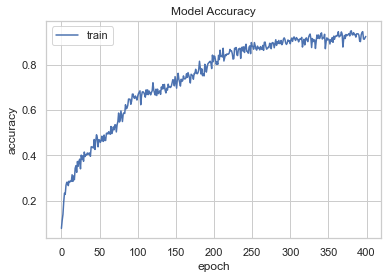

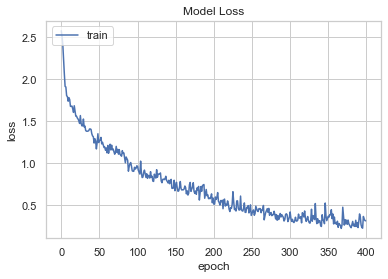

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            488448    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 95.000%


##### Confusion Matrix

240 is the number of test value in kfold_val / train_test_split


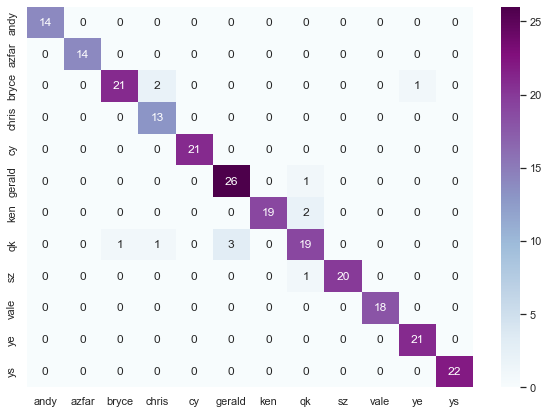

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

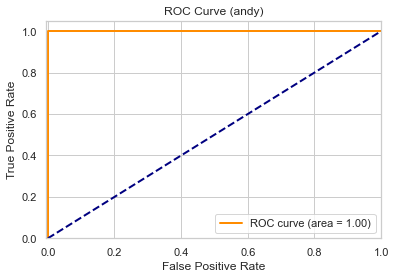

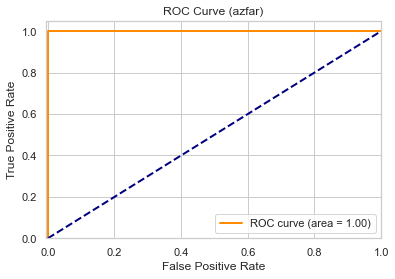

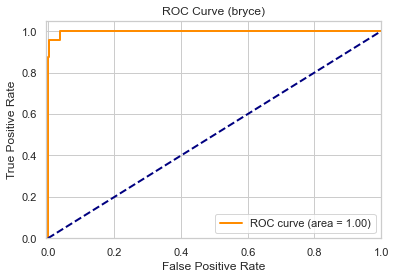

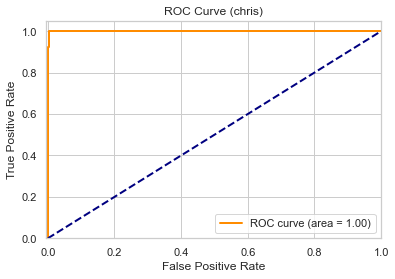

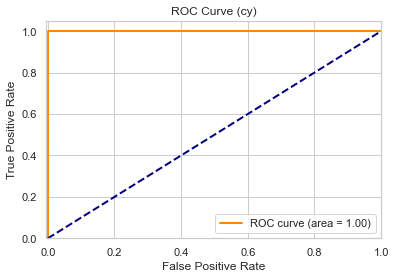

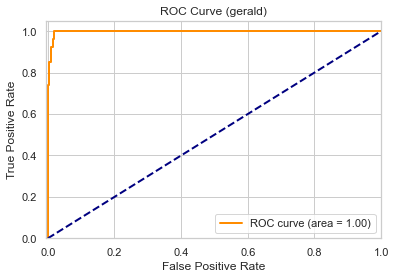

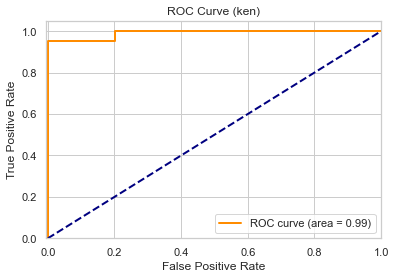

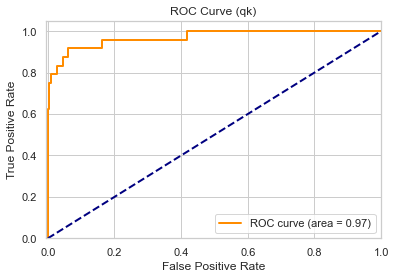

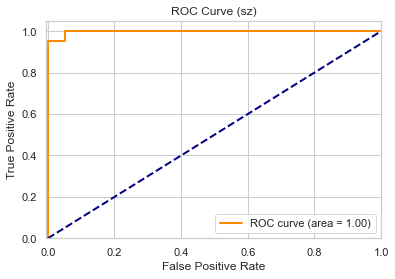

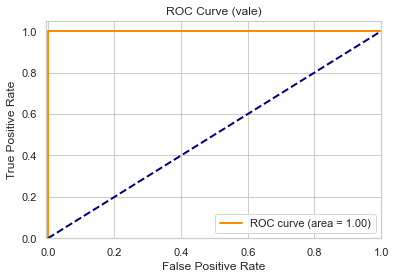

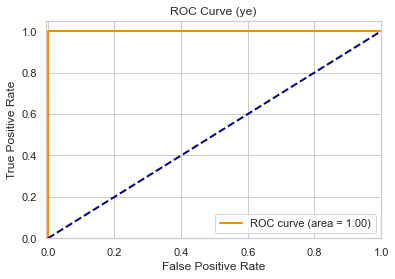

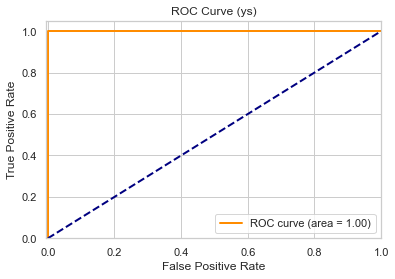

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

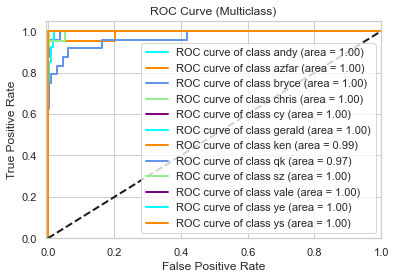

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

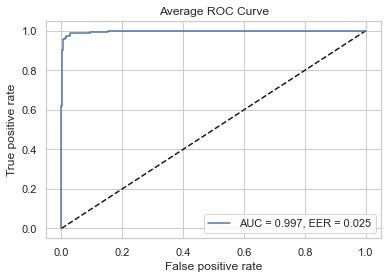

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'bryce' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye'
 'ys']


X | Features | Dataset Shape: (1200, 220)
Y | Classes  | Dataset Shape: (1200, 12)
There are a total of 12 classes.
Epoch 1/400
120/120 [==============================] - 6s 9ms/step - loss: 2.5737 - accuracy: 0.0742
Epoch 2/400
120/120 [==============================] - 1s 8ms/step - loss: 2.4320 - accuracy: 0.1350
Epoch 3/400
120/120 [==============================] - 1s 8ms/step - loss: 2.1627 - accuracy: 0.2100
Epoch 4/400
120/120 [==============================] - 1s 10ms/step - loss: 1.9700 - accuracy: 0.2358
Epoch 5/400
120/120 [==============================] - 1s 11ms/step - loss: 1.9733 - accuracy: 0.1992
Epoch 6/400
120/120 [==============================] - 1s 11ms/step - loss: 1.9140 - accuracy: 0.2208
Epoch 7/400
120/120 [==============================] - 1s 11ms/step - loss: 1.8753 - accuracy: 0.2300
Epoch 8/400
120/120 [==============================] 

120/120 [==============================] - 1s 10ms/step - loss: 1.0104 - accuracy: 0.6158
Epoch 79/400
120/120 [==============================] - 1s 10ms/step - loss: 0.9587 - accuracy: 0.6350
Epoch 80/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0133 - accuracy: 0.6267
Epoch 81/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0476 - accuracy: 0.6108
Epoch 82/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0081 - accuracy: 0.6208
Epoch 83/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0078 - accuracy: 0.6267
Epoch 84/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0383 - accuracy: 0.6242
Epoch 85/400
120/120 [==============================] - 1s 10ms/step - loss: 0.9334 - accuracy: 0.6425
Epoch 86/400
120/120 [==============================] - 1s 10ms/step - loss: 0.9758 - accuracy: 0.6492
Epoch 87/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0512 - 

120/120 [==============================] - 1s 11ms/step - loss: 0.6138 - accuracy: 0.7925
Epoch 158/400
120/120 [==============================] - 1s 10ms/step - loss: 0.7734 - accuracy: 0.7308
Epoch 159/400
120/120 [==============================] - 1s 9ms/step - loss: 0.7350 - accuracy: 0.7417
Epoch 160/400
120/120 [==============================] - 1s 9ms/step - loss: 0.7666 - accuracy: 0.7375
Epoch 161/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6419 - accuracy: 0.7733
Epoch 162/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6281 - accuracy: 0.7900
Epoch 163/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6637 - accuracy: 0.7717
Epoch 164/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6903 - accuracy: 0.7575
Epoch 165/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6810 - accuracy: 0.7642
Epoch 166/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6884 -

120/120 [==============================] - 1s 9ms/step - loss: 0.4927 - accuracy: 0.8833
Epoch 237/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4128 - accuracy: 0.8858
Epoch 238/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4720 - accuracy: 0.8767
Epoch 239/400
120/120 [==============================] - 1s 9ms/step - loss: 0.5157 - accuracy: 0.8667
Epoch 240/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4855 - accuracy: 0.8775
Epoch 241/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4948 - accuracy: 0.8508
Epoch 242/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4554 - accuracy: 0.8767
Epoch 243/400
120/120 [==============================] - 1s 9ms/step - loss: 0.5326 - accuracy: 0.8567
Epoch 244/400
120/120 [==============================] - 1s 9ms/step - loss: 0.5650 - accuracy: 0.8425
Epoch 245/400
120/120 [==============================] - 1s 9ms/step - loss: 0.5012 - a

120/120 [==============================] - 1s 9ms/step - loss: 0.3399 - accuracy: 0.9117
Epoch 316/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3127 - accuracy: 0.9275
Epoch 317/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3196 - accuracy: 0.9208
Epoch 318/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4130 - accuracy: 0.8975
Epoch 319/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3321 - accuracy: 0.9167
Epoch 320/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4465 - accuracy: 0.8917
Epoch 321/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3321 - accuracy: 0.9225
Epoch 322/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4426 - accuracy: 0.8875
Epoch 323/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4380 - accuracy: 0.8750
Epoch 324/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3734 - a

120/120 [==============================] - 1s 9ms/step - loss: 0.4194 - accuracy: 0.8933
Epoch 395/400
120/120 [==============================] - 1s 9ms/step - loss: 0.2952 - accuracy: 0.9292
Epoch 396/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3183 - accuracy: 0.9283
Epoch 397/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3893 - accuracy: 0.9025
Epoch 398/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4836 - accuracy: 0.8750
Epoch 399/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3779 - accuracy: 0.9025
Epoch 400/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3106 - accuracy: 0.9142


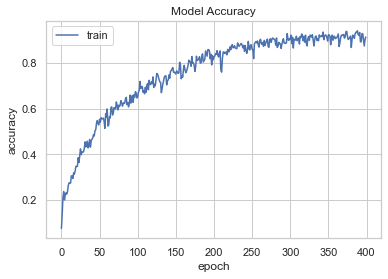

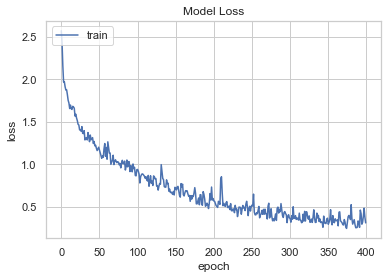

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,Co5mical,0.073992,0.003000,0.076992,0.094482,0.168474,0.091483,0.045362,0.136844,...,0.002609,0.001499,0.042155,0.029788,0.051080,0.038712,0.499024,0.573016,0.566388,0.640380
1,andy,Co5mical,0.100974,0.012187,0.113161,0.101644,0.202618,0.089456,0.033577,0.123034,...,0.004042,0.005144,0.048238,0.056383,0.063579,0.071723,0.518507,0.619481,0.597307,0.698281
2,andy,Co5mical,0.089725,0.045267,0.134991,0.167849,0.257574,0.122583,0.005957,0.128540,...,0.009055,0.005173,0.087968,0.064734,0.095156,0.071922,0.504553,0.594277,0.596016,0.685741
3,andy,Co5mical,0.067997,0.054379,0.122376,0.144052,0.212049,0.089673,0.000993,0.090666,...,0.007376,0.004978,0.081239,0.065912,0.085884,0.070557,0.477528,0.545525,0.563112,0.631109
4,andy,Co5mical,0.102257,0.003956,0.106213,0.089189,0.191446,0.085233,0.045437,0.130670,...,0.002313,0.003616,0.024290,0.036328,0.048092,0.060130,0.470455,0.572712,0.537894,0.640151


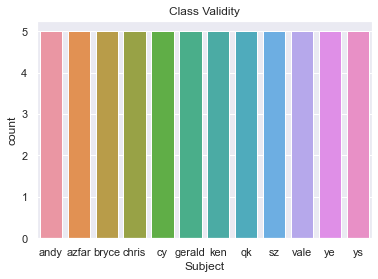

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['andy', 'azfar', 'bryce', 'chris', 'cy', 'gerald', 'ken', 'qk', 'sz', 'vale', 'ye', 'ys']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model is: " + str(match_header))

Accuracy of the Model is: 58/60 (96.66666666666667%)


In [32]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:55:17
